# Highway environment benchmarking
---

To compare the REINFORCE agents with the exosting baselines, we will use the solutions, provided by [rl-agents](https://github.com/eleurent/rl-agents) library, that has been mentioned in the environment's [README](https://github.com/Farama-Foundation/HighwayEnv/blob/master/README.md) file.

In particular, we will use the Random agent and the Value Iteration agent with default hyperparameters. The results will be compared with the REINFORCE agent, trained in the previous notebook.

# Prerequisites

The bench marks relies on legacy modules ([rl-agents](https://github.com/eleurent/rl-agents) and [finite-mdp](https://github.com/eleurent/finite-mdp) by Edouard Leurent) which must be downloaded from git manually. For these reasons we recommend to run this notebook in the separate local environment and/or after running the previous notebooks.

## Installation

Suppose you have already installed the required packages in the previous notebooks.

```bash

cd crash-course-to-reinforce
poetry install

```

After you have fininsed the previous notebooks, you can install the required packages by running the following commands:

```bash
# For Windows
.venv/Scripts/activate

# For Mac/Linux
source .venv/bin/activate

pip install git+https://github.com/eleurent/rl-agents
pip install git+https://github.com/eleurent/finite-mdp

```

This installation downgrade some of the packages, so you may need to restart the kernel.

# Benchmarking

For benchmarking we have chosen two agents: Random Agent and Value Iteration Agent. The Random Agent is a simple agent that chooses a random action at each step. The Value Iteration Agent is a model-based agent that uses the value iteration algorithm to compute the optimal policy for the environment. The environment itself is approximated by a finite MDP, using previously installed packages.

All agent's hyperparameters have been taken from the existing benchmarks in the [rl-agents](https://github.com/eleurent/rl-agents/tree/master/scripts/configs/HighwayEnv) library.

For the environment, we have defined two hyperparameters configurations for policy frequency of 1 Hz and 5Hz, setting the simulation frequency to 5 Hz and 25 Hz, respectively. The observation space is the same as in other notebooks.

In [ ]:
from src.baselines_utils import benchmark, show_metrics
from src.utils import mp4_to_gif

Define the enviornments, agents and the number of runs.

In [2]:
RUNS = 1000 # number of runs for each experiment

ENV_CONFIGS = {
    "Highway 1Hz": {
        "simulation_frequency": 5,  # follow the Sampling theorem
        "policy_frequency": 1,
        "duration": 40,  # episode duration in seconds
        "action": {"type": "DiscreteMetaAction"},  # use the discrete meta-action space
        "observation": {
            "type": "OccupancyGrid",
            "grid_size": [[-5, 5], [-5, 5]],
            "grid_step": [2.0, 2.0],
            "features": ["presence", "vx"],  # presence and relative speed
        },
        "offscreen_rendering": True,
    },
    "Highway 5Hz": {
        "simulation_frequency": 25,
        "policy_frequency": 5,
        "duration": 40,
        "action": {"type": "DiscreteMetaAction"},
        "observation": {
            "type": "OccupancyGrid",
            "grid_size": [[-5, 5], [-5, 5]],
            "grid_step": [2.0, 2.0],
            "features": ["presence", "vx"],
        },
        "offscreen_rendering": True,
    },
}

AGENT_CONFIGS = {
    "Value Iteration": {
        "__class__": "<class 'rl_agents.agents.dynamic_programming.value_iteration.ValueIterationAgent'>",  # noqa: E501
        "env_preprocessors": [{"method": "simplify"}],
        "iterations": 10,
    },
    "Random Agent": {
        "__class__": "<class 'rl_agents.agents.simple.random.RandomUniformAgent'>",
        "env_preprocessors": [{"method": "simplify"}],
        "budget": 120,
    },
}

Run the results and go out to touch the grass for several hours.

In [3]:
results = benchmark(env_configs=ENV_CONFIGS, agent_configs=AGENT_CONFIGS, episodes=RUNS)
# Convert the records of the run, so we can display them inside the notebook
mp4_to_gif("results/baselines")

/home/medric/Desktop/appV2/databasePochta/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/medric/Desktop/crash-course-to-reinforce/results/baselines folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Run 1/4: 100%|██████████| 1000/1000 [38:28<00:00,  2.31s/episode]
/home/medric/Desktop/appV2/databasePochta/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/medric/Desktop/crash-course-to-reinforce/results/baselines folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Run 4/4: 100%|██████████| 1000/1000 [41:47<00:00,  2.51s/episode] 


# Results discussion

Looking at runs completed in 1Hz environment, we can see that the Value Iteration Agent works well, reaching the destination point (finishing the run without collisions) in the majority of cases. The Random Agent, on the other hand, has a very low success rate, establishing the universally bad performance of the random policy.

<p align="center">
    <img width="600" src="results/baselines/Value%20Iteration-Highway%201Hz-episode-0.gif" alt="Value Iteration agent">
    <img width="600" src="results/baselines/Random%20Agent-Highway%201Hz-episode-0.gif" alt="Random agent">
    <p align="center">Fig. 1 - Value Iteration Agent (top) and Random Agent (bottom) in 1Hz environment</p>
</p>

At that moment we can say, that the Value Iteration works quiet well in the environment and there is no reason to use the REINFORCE agent. The problem is solved. Happy end!

Unfortunately, everything ruins as soon as we increase the policy frequency up to 5Hz. The Value Iteration Agent fails to reach the destination point in the majority of cases, while the Random Agent continues to work bad.

<p align="center">
    <img width="600" src="results/baselines/Value%20Iteration-Highway%205Hz-episode-0.gif" alt="Value Iteration agent">
    <img width="600" src="results/baselines/Random%20Agent-Highway%205Hz-episode-0.gif" alt="Random agent">
    <p align="center">Fig. 2 - Value Iteration Agent (top) and Random Agent (bottom) in 5Hz environment</p>
</p>

By increasing the policy frequency, the environment becomes more complex poorly approximated by the finite MDP. The Value Iteration Agent, which relies on the MDP approximation, fails to find the optimal policy in this case, as it is not able to capture the environment dynamics accurately enough. The Random Agent, as expected, performs poorly in both cases.

## Metrics

As the increase of the policy frequecny elongates the time of the episode, we will use the normalized length of the episode the main metric. The length is normalized by the maximum possible number of steps in the episode under the given environment configuration and calsulated as follows:

$$
l_{\text{norm}} = \frac{l}{f_{\text{policy}} \cdot T_{\text{episode}}},
$$

where:

- $l$ is the length of the episode in steps,
- $f_{\text{policy}}$ is the policy frequency in Hz,
- $T_{\text{episode}}$ is the duration of the episode in seconds.

As the reward is not normalized, we can make the conclusions only by comparing the Value Iteration agent with the Random one under the same environment's configuration.

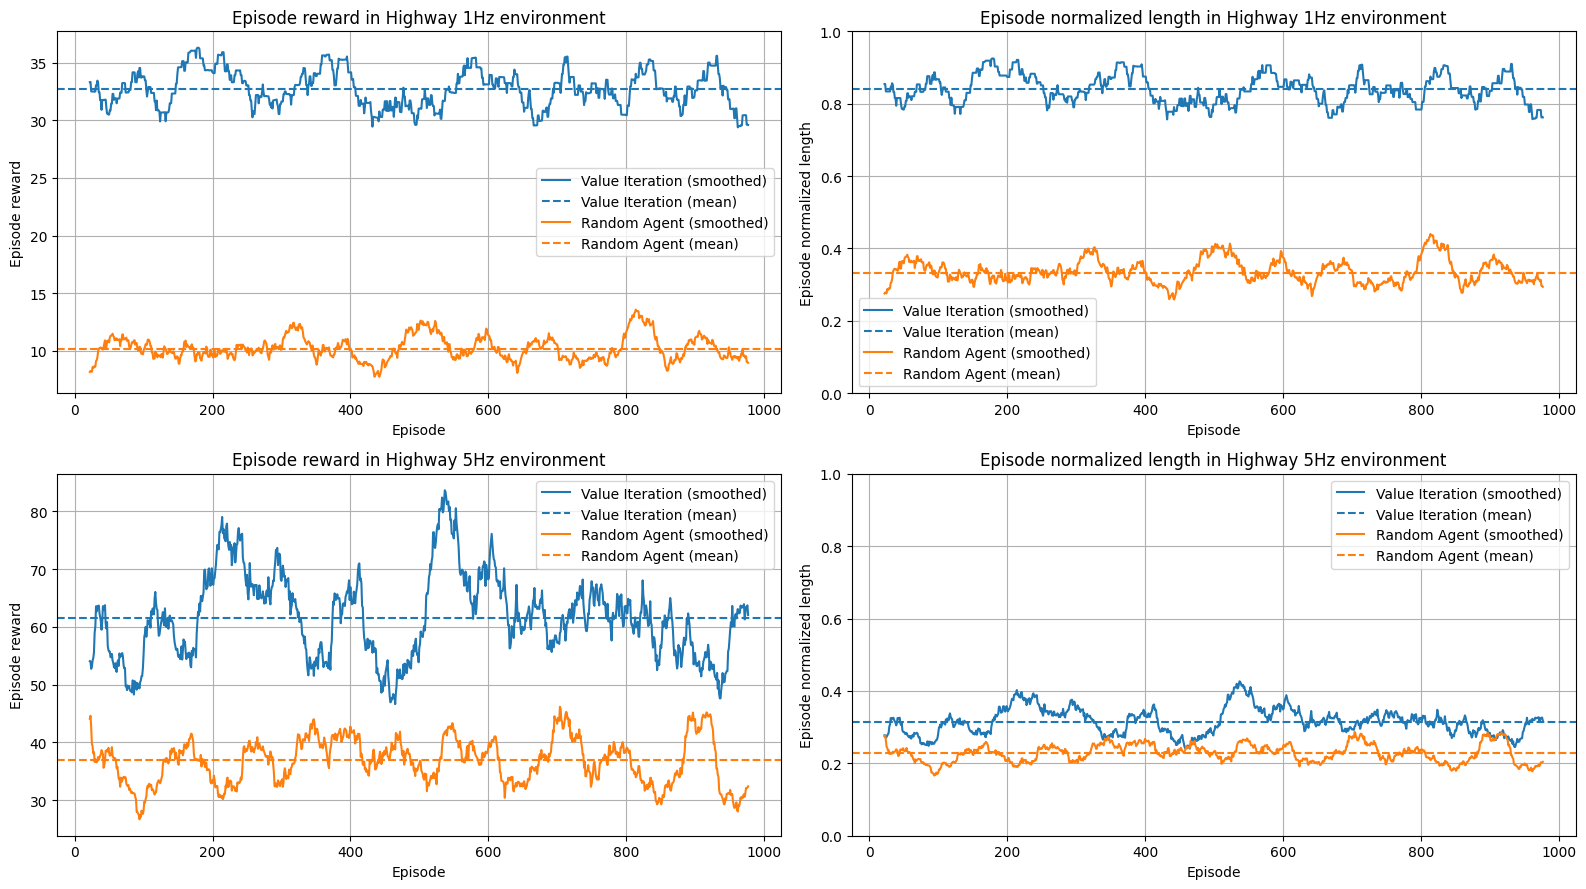

In [4]:
import pandas as pd  # noqa: F401

# If you need to update the results only, you can skip the benchmarking and load the
# results from the CSV file

# results = pd.read_csv("results/baselines/results.csv")

fig = show_metrics(results, roll_length=45)

<p align="center">Fig. 3 - Value Iteration Agent and Random Agent metrics in both environments.</p>

The Figure 3 shows, that the Value Iteration agent fails at high policy frequency. This happens, as the higher frequency makes the environment more complex and the MDP approximation less accurate. In particular, the agent does not considers the vehicles sizes and cahneg lines too early or too late, causing the collsions. This does not occures in the 1Hz environment, as the minimal time between the actions is enough to distant the vehicles.

# Conclusion

The Value Iteration Agent works well in the 1Hz environment, but fails in the 5Hz environment. The Random Agent performs poorly in both cases. So, we need the REINFORCE agent to solve the problem in the 5Hz environment.